In [1]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint

from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter


import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
from qiskit.quantum_info import *
import os
import pickle
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import re
import numpy as np
from pathlib import Path
# Global variable to store cached data in memory
global_cache_data_analog = None
global_processed_files_analog = None
global_cache_data_digital = None
global_processed_files_digital = None

In [2]:
from readin_data_runs import get_cached_data_once_analog, get_cached_data_once_digital, process_new_files_analog, process_new_files_digital

In [ ]:

num_epochs = 1500
# # Process files by each N_ctrl and update the cache independently
# cached_data_analog_nctrl3 , processed_files_analog_nctrl3 = get_cached_data_direct_path(nctrl3_path, N_ctrl)
# Main loop for different N_ctrl values
N_ctrls = [1, 2,3]
num_train = 20
reservoir_counts = [1, 2, 3,4,5,6,7,8]
processed_files_global_digital = set()
base_path = f'/Users/sophieblock/QRCCapstone/gate_results_trainable_global/trainsize_{num_train}_epoch1500_per_param_opt/'
# base_path = f'/Users/sophieblock/Downloads/debug/digital_results_trainable_global/trainsize_{num_train}_epoch1500_per_param_costcut_1e-10/'

cached_data_digital, processed_files_digital = get_cached_data_once_digital(base_path)


base_path = f'/Users/sophieblock/QRCCapstone/analog_results_trainable_global/trainsize_{num_train}_epoch{num_epochs}_per_param_opt/'
# base_path = f'/Users/so714f/Documents/offline/qrc/analog_results_trainable_global/trainsize_{num_train}_epoch1000/0/'
cached_data_analog, processed_files_analog = get_cached_data_once_analog(base_path)


Cache file loaded from disk: /Users/sophieblock/QRCCapstone/analog_results_trainable_global/trainsize_20_epoch1500_per_param_opt/cached_results.pkl
Loaded 923 processed files from cache. Took 86.47s.


In [47]:
def get_dataframe(cached_data_temp, model_type = "Digital"):
    for N_ctrl in cached_data_temp:
        for gate, gate_data in cached_data_temp[N_ctrl].items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        original = results.get('test_results', [])
                        new_vals = []
                        for f in original:
                            if f > 1.0:
                                delta = f - 1.0       # how far above 1.0
                                reflected = 1.0 - delta  # reflect about 1.0
                                # If 'reflected' dips below 0 (which can happen if f>2),
                                # you might clamp it to 0.0 or do something else:
                                if reflected < 0:
                                    reflected = 0.0
                                print(f"[PASS 1] Reflecting fidelity {f:.6f} about 1.0 => {reflected:.6f} "
                                    f"(Gate={gate}, N_C={N_ctrl}, N_R={reservoir_count}, T={trotter_step})")
                                new_vals.append(reflected)
                            else:
                                new_vals.append(f)
                        results['test_results'] = new_vals
    for N_ctrl in cached_data_temp:
        for gate, gate_data in cached_data_temp[N_ctrl].items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        # Just clamp any test_results fidelity to <= 1.0
                        original = results.get('test_results', [])
                        clamped_vals = [min(1.0, f) for f in original]
                        results['test_results'] = clamped_vals
                        
    tmp_rows = []
    for N_ctrl in cached_data_temp:
        for gate, gate_data in cached_data_temp[N_ctrl].items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        row = {
                            'Type': model_type,
                            'N_C': N_ctrl,
                            'Gate': gate,
                            'N_R': reservoir_count,
                            'Trotter_Step': trotter_step,
                        }
                        # Include *all* keys from `results` so we don't drop anything
                        for k, v in results.items():
                            row[k] = v

                        tmp_rows.append(row)

    tmp_df = pd.DataFrame(tmp_rows)
        
   

    def keep_iqr_5_95(arr):
        # If array empty or all identical, just return it
        if len(arr) < 2:
            return arr
        p5, p95 = np.percentile(arr, [0, 95])
        filtered = [x for x in arr if p5 <= x <= p95]
        # If everything got filtered out, you could decide to keep them all
        # or do something else. Here we allow an empty list if it's all outliers.
        return filtered if filtered else arr

    # tmp_df['test_results'] = tmp_df['test_results'].apply(keep_iqr_5_95)

    tmp_df['avg_fidelity'] = tmp_df['test_results'].apply(
        lambda arr: np.mean(arr) if len(arr) else 1.0
    )

    group_cols = ['N_C', 'N_R', 'Trotter_Step']
    tmp_df['local_max_avg_fid'] = (
        tmp_df.groupby(group_cols)['avg_fidelity'].transform('max')
    )


    def fix_any_ones_partially(row):
        arr = row['test_results']
        if len(arr) > 0 and any(x == 1.0 for x in arr):
            local_max = row['local_max_avg_fid']
            new_arr = []
            for x in arr:
                if x == 1.0:
                    new_arr.append(local_max)
                else:
                    new_arr.append(x)
            print(f"[PASS 2] Partially replacing any 1.0 entries "
                f"with local_max_avg_fid={local_max:.4e} "
                f"(Gate={row['Gate']}, N_C={row['N_C']}, "
                f"N_R={row['N_R']}, T={row['Trotter_Step']})")
            return new_arr
        return arr
    tmp_df['test_results'] = tmp_df.apply(fix_any_ones_partially, axis=1)

    
    ##############################################################################
    # WRITE BACK THE UPDATED `test_results` INTO `cached_data_temp`
    # so your original code snippet can run unmodified.
    ##############################################################################
    for idx, row in tmp_df.iterrows():
        N_ctrl = row['N_C']
        gate = row['Gate']
        reservoir_count = row['N_R']
        trotter_step = row['Trotter_Step']
        
        # Find matching entry in the results_list
        results_list = cached_data_temp[N_ctrl][gate][reservoir_count][trotter_step]
        found_entry = False
        for results in results_list:
            # If you have a unique 'run' key, match on that
            if 'run' in row and results.get('run') == row['run']:
                results['test_results'] = row['test_results']
                found_entry = True
                break

        # If you have no unique ID, you must figure out a safe way to match
        # For now, we skip if not found:
        if not found_entry:
            pass



    ##############################################################################
    # PASS 2: RUN YOUR ORIGINAL CODE TO BUILD THE FINAL `all_data_df` WITH ALL KEYS
    ##############################################################################
    rows = []
    negative_fidelity_values = []

    global_min_error = 100  # from your snippet
    N_ctrls = [2,3]        # or whatever your loop over N_ctrl is

    for N_ctrl in N_ctrls:
        data_i = cached_data_temp[N_ctrl]
        for gate, gate_data in data_i.items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        avg_fidelity = results.get('fidelity', np.nan)
                        std_fidelity = np.nanstd(results.get('test_results', []))

                        if pd.isna(avg_fidelity):
                            raise ValueError(
                                f"NaN in avg_fidelity! Gate: {gate}, N_C: {N_ctrl}, "
                                f"N_R: {reservoir_count}, Trotter_Step: {trotter_step}, "
                                f"Run: {results.get('run', None)}"
                            )

                        log_infidelities = []
                        infidelities, fidelities = [], []
                        num_clipped = {}
                        all_og_fidelities = {}

                        test_results = results.get('test_results', [])
                        optimal_min_error = None
                        optimal_jitter_scale = None

                        # Step 1: dynamic min_error + jitter
                        non_clipped_fids = [
                            f for f in test_results
                            if 0 < f < 1.0
                        ]
                        if non_clipped_fids:
                            sorted_valid = sorted(non_clipped_fids)
                            n = len(sorted_valid)
                            std_dev = np.std(sorted_valid)
                            std_err = std_dev / np.sqrt(n) if n > 1 else global_min_error
                            optimal_min_error = 1.0 - sorted_valid[-1]
                            if global_min_error > optimal_min_error:
                                global_min_error = max(1e-9, optimal_min_error)
                            optimal_jitter_scale = (
                                std_dev / 2
                                if std_dev/2 < optimal_min_error
                                else optimal_min_error
                            )
                        else:
                            optimal_min_error = global_min_error
                            optimal_jitter_scale = global_min_error

                        # Step 2: Process each fidelity
                        clipped_count = 0
                        for i, f in enumerate(test_results):
                            all_og_fidelities[i] = f
                            inf = 1.0 - f

                            if inf <= 1e-8:
                                clipped_count += 1
                                jitter = np.random.uniform(-optimal_jitter_scale, 
                                                        optimal_jitter_scale)
                                num_clipped[i] = {'fidelity': f, 'jit': jitter}
                                inf = optimal_min_error + jitter
                                # print(f'triggered')
                                # print(f"\nGate={results['gate']} => test_results stats:")
                                # print(f"  Min={np.min(test_results):.7e}, Max={np.max(test_results)}, Var={np.var(test_results)}, Mean={np.mean(test_results):.9f}")
                                assert inf > 0, (
                                    f"Adjusted infidelity is non-positive: i={i}, "
                                    f"min_error={optimal_min_error}, jitter={jitter}."
                                )
                                f = 1.0 - inf

                            infidelities.append(inf)
                            fidelities.append(f)
                            log_infidelities.append(np.log10(inf))

                        # Step 3: Build row
                        avg_fidelity = np.mean(fidelities)
                        avg_infidelity = np.mean(infidelities)

                        row = {
                            'Type': model_type,
                            'N_C': int(N_ctrl),
                            'Trotter_Step': int(trotter_step),
                            'Gate': results['gate'],
                            'N_R': int(reservoir_count),
                            'Avg_Fidelity': avg_fidelity,
                            'std_fidelity': std_fidelity,
                            'Avg_infidelity': avg_infidelity,
                            'var_infid': np.var(infidelities),
                            'Error_Test_Results': log_infidelities,
                            'Avg Error': (np.nanmean(log_infidelities) 
                                        if log_infidelities else np.nan),
                            'infidelities': infidelities,
                            'fidelities': fidelities,
                            'Costs': results.get('costs', []),
                            'Test Results': test_results,
                            'N_params': results.get('param_count', np.nan),
                            'run': results.get('run', None),
                           
                          
                        }

                        rows.append(row)

    all_data_df = pd.DataFrame(rows)
    return all_data_df

df_digital = get_dataframe(cached_data_digital, "Digital")
df_analog = get_dataframe(cached_data_analog, "Analog")

df_combined = pd.concat([df_digital, df_analog])


In [48]:

df_digital = get_dataframe(cached_data_digital, "Digital")
df_analog = get_dataframe(cached_data_analog, "Analog")

df_combined = pd.concat([df_digital, df_analog])


[Text(0, 1e-10, '$\\mathdefault{10^{-10}}$'), Text(0, 1e-09, '$\\mathdefault{10^{-9}}$'), Text(0, 1e-08, '$\\mathdefault{10^{-8}}$'), Text(0, 1e-07, '$\\mathdefault{10^{-7}}$'), Text(0, 1e-06, '$\\mathdefault{10^{-6}}$'), Text(0, 1e-05, '$\\mathdefault{10^{-5}}$'), Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'), Text(0, 0.001, '$\\mathdefault{10^{-3}}$'), Text(0, 0.01, '$\\mathdefault{10^{-2}}$'), Text(0, 0.1, '$\\mathdefault{10^{-1}}$'), Text(0, 1.0, '$\\mathdefault{10^{0}}$'), Text(0, 10.0, '$\\mathdefault{10^{1}}$'), Text(0, 100.0, '$\\mathdefault{10^{2}}$')]


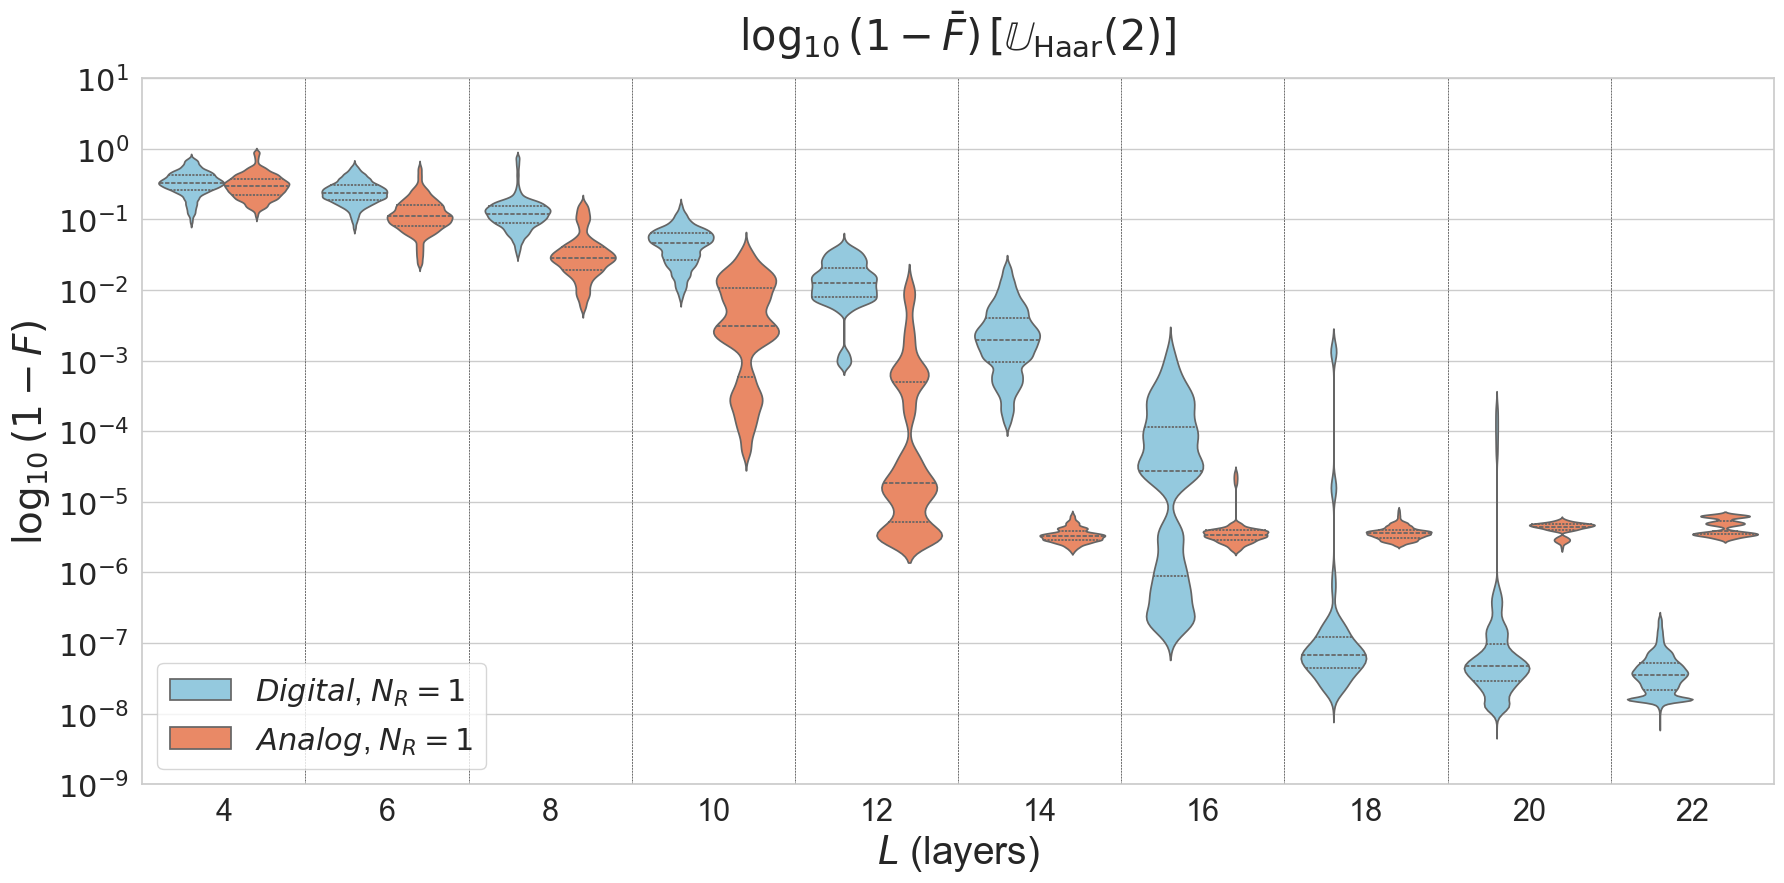

In [36]:
# ------------------------------
# 1) Subset your DataFrame
# ------------------------------
N_ctrl = 2
NR = 1

data_df = df_combined[
    (df_combined['N_C'] == N_ctrl) & (df_combined['N_R'] == NR)
]

# Find the common Trotter steps across all N_Rs
grouped_trotter_steps = data_df.groupby(['Trotter_Step', 'Type']).size().unstack(fill_value=0)
valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

test_results_df = data_df[data_df['Trotter_Step'].isin(valid_trotter_steps)]

# Explode the list of infidelities so each entry is a row
test_results_df = test_results_df.explode('infidelities')
test_results_df = test_results_df.dropna(subset=['infidelities'])

# ------------------------------
# 2) Set up the Plot
# ------------------------------
custom_palette = {'Analog': 'coral', 'Digital': 'skyblue'}
fig, ax = plt.subplots(1, 1, figsize=(18, 9))

# Use order=... to ensure Trotter steps appear in sorted order
sorted_steps = sorted(test_results_df['Trotter_Step'].unique())

sns.violinplot(
    x='Trotter_Step',
    y='infidelities',
    hue='Type',
    data=test_results_df,
    ax=ax,
    palette=custom_palette,
    log_scale=True,             # log-scale on the y-axis
    density_norm='width',
    inner='quartile',
    saturation=0.75,
    order=sorted_steps          # ensure sorted categories
)

# ------------------------------
# 3) Customize the Axes/Legend
# ------------------------------
ax.set_title(
    f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$',
    fontsize=30, 
    pad=20
)
ax.set_xlabel('$L$ (layers)', fontsize=28)
ax.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[:2],
    [f'${label}$, $N_R = 1$' for label in labels[:2]],
    title_fontsize=16,
    loc='lower left',
    fontsize=22
)

yticks = ax.get_yticklabels()
print(yticks)
ax.tick_params(axis='y', labelsize=22)
ax.tick_params(axis='x', labelsize=22)
# Use unique Trotter_Steps to match the sorted steps for vertical lines
unique_x_ticks = sorted(test_results_df['Trotter_Step'].unique()) 
positions = range(1, len(unique_x_ticks), 1)
for pos in positions:
    ax.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)
ymin, ymax = ax.get_ylim()

# If data never dips below 1e-12 or above 1e+4, Seaborn won't label them by default,
# but we can force them to appear by enumerating all exponents.
lowest_exp = int(np.floor(np.log10(ymin)))
highest_exp = int(np.ceil(np.log10(ymax)))

# Build a list of all 10^exponent for each integer exponent in this range
exponents = range(lowest_exp, highest_exp + 1)
all_ticks = [10**e for e in exponents]

# Apply them as your new ticks
ax.set_yticks(all_ticks)
ax.set_yticklabels([f'$10^{{{e}}}$' for e in exponents], fontsize=22)

# ------------------------------
# 4) Final Layout and Show
# ------------------------------
plt.tight_layout()
plt.show()

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_46246/2565849131.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({
/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_46246/2565849131.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


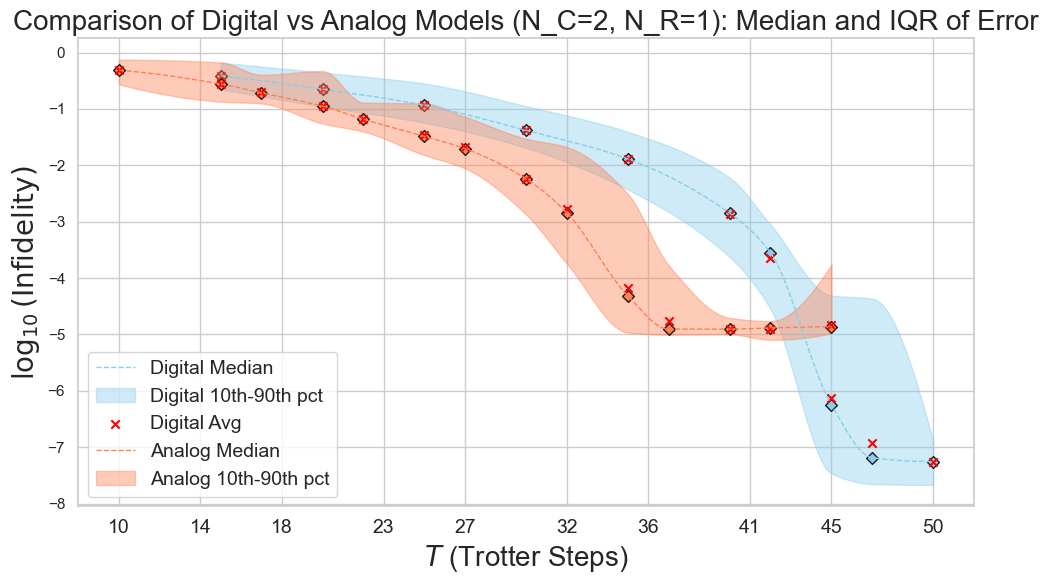

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

def plot_smoothed_comparison(df, N_ctrl, N_R, xlabel, ylabel, title, std_metric='Error_Test_Results'):
    """
    For the specified N_ctrl and N_R, compare Digital vs Analog models by plotting,
    for each Trotter_Step, the median and 20th/80th percentile band of the given error metric.
    
    The error metric (std_metric) is expected to be stored as a list (per run).
    The function concatenates the lists across runs per Trotter_Step before computing statistics.
    
    Args:
        df (pd.DataFrame): Combined DataFrame with both Digital and Analog runs.
        N_ctrl (int): The number of control qubits to filter on.
        N_R (int): The reservoir count to filter on.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): Plot title.
        std_metric (str): Column to use for computing statistics (e.g. 'Error_Test_Results').
    """
    plt.figure(figsize=(10, 6))
    
    # Filter for the specified N_ctrl and N_R
    df_filtered = df[(df['N_C'] == N_ctrl) & (df['N_R'] == N_R)].copy()
    
    # Loop over model types (Digital and Analog)
    for model_type, color in zip(['Digital', 'Analog'], ['skyblue', 'coral']):
        df_type = df_filtered[df_filtered['Type'] == model_type].copy()
        
        # Group by Trotter_Step and compute statistics by flattening the list-based std_metric.
        # Each row's std_metric is assumed to be a list (e.g. log-infidelities).
        stats = (
            df_type.groupby('Trotter_Step', group_keys=False)
            .apply(lambda group: pd.Series({
                'median': np.median(np.concatenate(group[std_metric].values)),
                'q10': np.percentile(np.concatenate(group[std_metric].values), 0),
                'q90': np.percentile(np.concatenate(group[std_metric].values), 100),
                'avg': np.mean(np.concatenate(group[std_metric].values))
            }))
            .reset_index()
        )
        
        # Skip if no data is available for this model_type
        if stats.empty:
            continue
        
        # Use PCHIP interpolation for smooth curves over Trotter_Step.
        x = stats['Trotter_Step'].values
        pchip_median = PchipInterpolator(x, stats['median'])
        pchip_lower = PchipInterpolator(x, stats['q10'])
        pchip_upper = PchipInterpolator(x, stats['q90'])
        
        # Generate a fine-grained x-axis for smooth plotting.
        x_fine = np.linspace(x.min(), x.max(), 300)
        median_smooth = pchip_median(x_fine)
        lower_smooth = pchip_lower(x_fine)
        upper_smooth = pchip_upper(x_fine)
        
        # Plot the smoothed median line and fill between the 20th and 80th percentile curves.
        plt.plot(x_fine, median_smooth, linestyle='--', lw=1, color=color,
                 label=f'{model_type} Median')
        plt.fill_between(x_fine, lower_smooth, upper_smooth, color=color, alpha=0.4,
                         label=f'{model_type} 10th-90th pct')
        # Also plot the raw median points.
        plt.scatter(x, stats['median'], marker='D', color=color, edgecolor='k')
        # And optionally the average (as red "x" markers) – plotted only for one type to avoid duplicate labels.
        plt.scatter(x, stats['avg'], marker='x', color='red', 
                    label=f'{model_type} Avg' if model_type=='Digital' else None)
    
    # Customize axes, title, and legend.
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    
    # Set a limited number of x-ticks.
    num_xticks = 10
    x_ticks = np.linspace(df_filtered['Trotter_Step'].min(), df_filtered['Trotter_Step'].max(), num_xticks, dtype=int)
    plt.xticks(x_ticks, [str(tick) for tick in x_ticks], fontsize=14)
    
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example call:
# Compare Digital vs Analog for N_ctrl=2 and N_R=1 using the 'Error_Test_Results' metric.
plot_smoothed_comparison(
    df=df_combined,
    N_ctrl=3,
    N_R=1,
    xlabel='$T$ (Trotter Steps)',
    ylabel=r'$\log_{10}(\text{Infidelity})$',
    title='Comparison of Digital vs Analog Models (N_C=2, N_R=1): Median and IQR of Error',
    std_metric='Error_Test_Results'
)

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_46246/907960616.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({
/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_46246/907960616.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


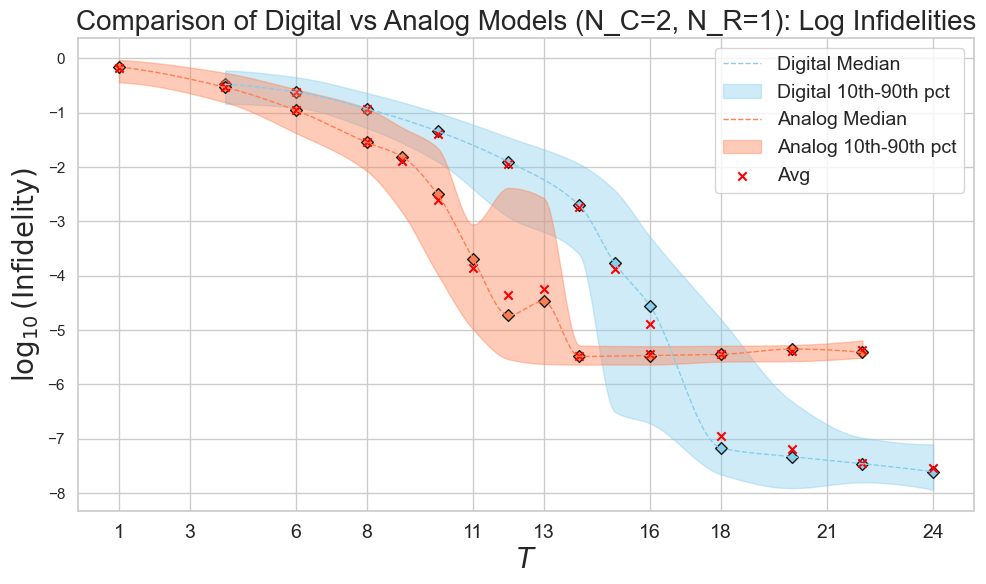

In [72]:
def plot_smoothed_comparison_infidelities(
    df, 
    N_ctrl, 
    N_R, 
    xlabel, 
    ylabel, 
    title, 
    infidelity_col='infidelities'
):
    """
    Compare Digital vs Analog models by plotting, for each Trotter_Step, the median and
    10th/90th percentile band of log10(infidelities).

    1) Filters the combined DataFrame `df` for the specified N_ctrl, N_R, and Type in ['Digital','Analog'].
    2) For each Trotter_Step, flattens the array of infidelities, converts them to log10,
       and computes median, 10th, and 90th percentiles.
    3) Uses a PCHIP interpolator to produce a smooth curve of the median and fills between
       the smoothed 10th and 90th percentile curves.

    Args:
        df (pd.DataFrame): Combined DataFrame with both Digital and Analog runs.
                          Must have columns 'N_C', 'N_R', 'Trotter_Step', 'Type', and `infidelity_col`.
        N_ctrl (int): Number of control qubits to filter on (N_C).
        N_R (int): Reservoir count to filter on (N_R).
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): Plot title.
        infidelity_col (str): The column name containing raw infidelities (default: 'infidelities').
    """
    plt.figure(figsize=(10, 6))
    
    # Filter for the specified N_C and N_R
    df_filtered = df[(df['N_C'] == N_ctrl) & (df['N_R'] == N_R)].copy()
    
    # Loop over model types (Digital, Analog)
    for model_type, color in zip(['Digital', 'Analog'], ['skyblue', 'coral']):
        df_type = df_filtered[df_filtered['Type'] == model_type].copy()
        
        # Group by Trotter_Step and compute stats of log10(infidelities)
        stats = (
            df_type.groupby('Trotter_Step', group_keys=False)
            .apply(lambda group: pd.Series({
                # Flatten all infidelities across runs in this group
                # Then convert to log10
                'median': np.median(np.log10(np.concatenate(group[infidelity_col].values))),
                'q10':    np.percentile(np.log10(np.concatenate(group[infidelity_col].values)), 5),
                'q90':    np.percentile(np.log10(np.concatenate(group[infidelity_col].values)), 95),
                'avg':    np.mean(np.log10(np.concatenate(group[infidelity_col].values)))
            }))
            .reset_index()
        )
        
        if stats.empty:
            continue
        
        x = stats['Trotter_Step'].values
        
        # Build PCHIP interpolators
        pchip_median = PchipInterpolator(x, stats['median'])
        pchip_lower = PchipInterpolator(x, stats['q10'])
        pchip_upper = PchipInterpolator(x, stats['q90'])
        
        # Evaluate on a fine x-grid
        x_fine = np.linspace(x.min(), x.max(), 300)
        median_smooth = pchip_median(x_fine)
        lower_smooth = pchip_lower(x_fine)
        upper_smooth = pchip_upper(x_fine)
        
        # Plot median curve + shaded region
        plt.plot(
            x_fine, 
            median_smooth, 
            linestyle='--', 
            lw=1, 
            color=color,
            label=f'{model_type} Median'
        )
        plt.fill_between(
            x_fine, 
            lower_smooth, 
            upper_smooth, 
            color=color, 
            alpha=0.4,
            label=f'{model_type} 10th-90th pct'
        )
        
        # Plot the raw median points
        plt.scatter(x, stats['median'], marker='D', color=color, edgecolor='k')
        
        # Plot the average as red "x" for only one type to avoid repeated legend items
        plt.scatter(
            x, 
            stats['avg'], 
            marker='x', 
            color='red',
            label=f'Avg' if model_type == 'Analog' else None
        )
    
    # Customize the plot
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    
    # Set a limited number of x-ticks
    num_xticks = 10
    x_ticks = np.linspace(df_filtered['Trotter_Step'].min(), df_filtered['Trotter_Step'].max(), num_xticks, dtype=int)
    plt.xticks(x_ticks, [str(tick) for tick in x_ticks], fontsize=14)
    
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# Compare Digital vs Analog for N_ctrl=2, N_R=1, using raw infidelities -> log10(infidelities).
plot_smoothed_comparison_infidelities(
    df=df_combined,
    N_ctrl=2,
    N_R=1,
    xlabel='$T$',
    ylabel=r'$\log_{10}(\text{Infidelity})$',
    title='Comparison of Digital vs Analog Models (N_C=2, N_R=1): Log Infidelities',
    infidelity_col='infidelities'
)

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_46246/616993751.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({
/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_46246/616993751.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


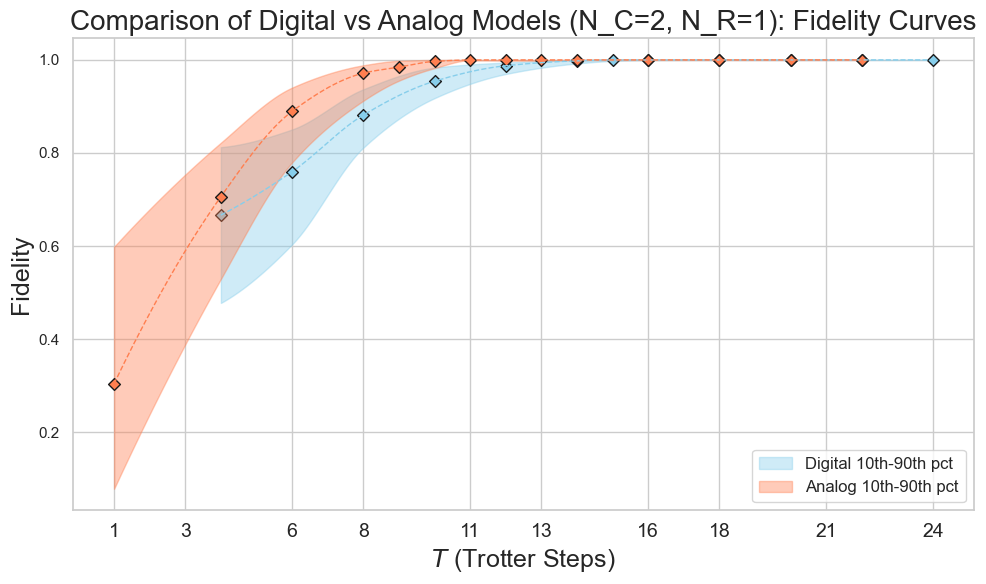

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

def plot_smoothed_comparison_fidelities(
    df,
    N_ctrl,
    N_R,
    xlabel,
    ylabel,
    title,
    fidelity_col='fidelities',
    lower_pct=10,
    upper_pct=90
):
    """
    Compare Digital vs Analog models by plotting, for each Trotter_Step, the median
    fidelity and a shaded region spanning the [lower_pct, upper_pct] percentiles.

    Steps:
      1. Filter the combined DataFrame `df` for the specified N_ctrl, N_R, and Types in ['Digital','Analog'].
      2. For each Trotter_Step, flatten the array of fidelities, compute median, lower_pct, upper_pct, and avg.
      3. Use a PCHIP interpolator to produce smooth curves of the median and the two percentile bounds.
      4. Overlay Digital and Analog on the same figure for direct comparison.

    Args:
        df (pd.DataFrame): Combined DataFrame (Digital + Analog).
                           Must have columns: 'N_C', 'N_R', 'Trotter_Step', 'Type', and `fidelity_col`.
        N_ctrl (int): Number of control qubits to filter on (N_C).
        N_R (int): Reservoir count to filter on (N_R).
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): Plot title.
        fidelity_col (str): The column name containing lists of fidelity values (default: 'fidelities').
        lower_pct (float): Lower percentile bound for the shaded region (default: 10).
        upper_pct (float): Upper percentile bound for the shaded region (default: 90).
    """
    plt.figure(figsize=(10, 6))
    
    # Filter for the specified N_C and N_R
    df_filtered = df[(df['N_C'] == N_ctrl) & (df['N_R'] == N_R)].copy()
    
    # Loop over model types (Digital, Analog) with distinct colors
    for model_type, color in zip(['Digital', 'Analog'], ['skyblue', 'coral']):
        df_type = df_filtered[df_filtered['Type'] == model_type].copy()
        
        # Group by Trotter_Step and compute statistics on flattened fidelity arrays
        stats = (
            df_type.groupby('Trotter_Step', group_keys=False)
            .apply(lambda group: pd.Series({
                'median': np.median(np.concatenate(group[fidelity_col].values)),
                'pct_low': np.percentile(np.concatenate(group[fidelity_col].values), lower_pct),
                'pct_high': np.percentile(np.concatenate(group[fidelity_col].values), upper_pct),
                'avg': np.mean(np.concatenate(group[fidelity_col].values))
            }))
            .reset_index()
        )
        
        if stats.empty:
            continue
        
        # Sort by Trotter_Step to avoid interpolation quirks
        stats = stats.sort_values('Trotter_Step')
        x = stats['Trotter_Step'].values
        
        # Build PCHIP interpolators for median and percentile bounds
        pchip_median = PchipInterpolator(x, stats['median'])
        pchip_lower = PchipInterpolator(x, stats['pct_low'])
        pchip_upper = PchipInterpolator(x, stats['pct_high'])
        
        # Evaluate on a fine x-grid
        x_fine = np.linspace(x.min(), x.max(), 300)
        median_smooth = pchip_median(x_fine)
        lower_smooth = pchip_lower(x_fine)
        upper_smooth = pchip_upper(x_fine)
        
        # Plot the median curve + shaded region
        plt.plot(
            x_fine, 
            median_smooth, 
            linestyle='--', 
            lw=1, 
            color=color,
            # label=f'{model_type} Median'
        )
        plt.fill_between(
            x_fine, 
            lower_smooth, 
            upper_smooth, 
            color=color, 
            alpha=0.4,
            label=f'{model_type} {lower_pct}th-{upper_pct}th pct'
        )
        
        # Plot raw median points
        plt.scatter(x, stats['median'], marker='D', color=color, edgecolor='k')
        
        # Plot average as red "x" for only one type to avoid repeated legend items
        # plt.scatter(
        #     x, 
        #     stats['avg'], 
        #     marker='x', 
        #     color='red',
        #     label=f'{model_type} Avg' if model_type == 'Digital' else None
        # )
    
    # Customize the plot
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.title(title, fontsize=20)
    
    # Choose a limited number of x-ticks
    num_xticks = 10
    x_ticks = np.linspace(df_filtered['Trotter_Step'].min(), df_filtered['Trotter_Step'].max(), num_xticks, dtype=int)
    plt.xticks(x_ticks, [str(tick) for tick in x_ticks], fontsize=14)
    
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Example usage:
plot_smoothed_comparison_fidelities(
    df=df_combined,
    N_ctrl=2,
    N_R=1,
    xlabel='$T$ (Trotter Steps)',
    ylabel='Fidelity',
    title='Comparison of Digital vs Analog Models (N_C=2, N_R=1): Fidelity Curves',
    fidelity_col='fidelities',  # or whichever column name holds your fidelity arrays
    lower_pct=10,
    upper_pct=90
)

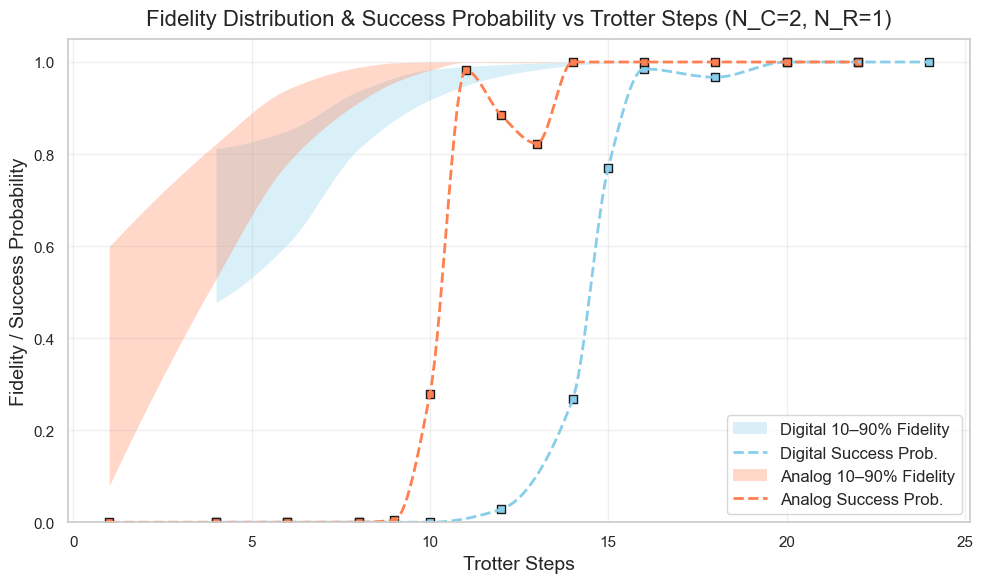

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

def plot_fidelity_distribution_and_success_probability_vs_trotter(
    df,
    N_ctrl=2,
    N_R=1,
    fidelity_threshold=0.999,
    lower_pct=10,
    upper_pct=90,
    fidelity_col='fidelities',
    figsize=(10, 6),
    title='Fidelity Distribution & Success Probability vs Trotter Steps',
    x_label='Trotter Steps',
    y_label='Fidelity / Success Probability',
    legend_fontsize=12,
    marker_size=6
):
    """
    For a single N_ctrl and N_R, compare Digital vs Analog by plotting:
      - A shaded band for the [lower_pct, upper_pct] percentile of fidelities (no boundary line)
      - A dashed line for success probability (fraction of runs > fidelity_threshold)

    We do *not* plot the median fidelity line. This yields only ONE line (success prob) per model,
    plus the shaded region for the distribution of fidelities.

    Args:
        df (pd.DataFrame): A DataFrame with columns:
            - 'Type' in ['Digital','Analog']
            - 'N_C' (number of control qubits)
            - 'N_R' (reservoir count)
            - 'Trotter_Step' (integer or float)
            - fidelity_col (str): each row is expected to have a list/array of fidelity values
                                  or single floats. We flatten them if they're lists.
        N_ctrl (int): Number of control qubits to filter on.
        N_R (int): Reservoir count to filter on.
        fidelity_threshold (float): The fidelity cutoff for "success" (default 0.999).
        lower_pct (float): Lower percentile for the fidelity band (default 10).
        upper_pct (float): Upper percentile for the fidelity band (default 90).
        fidelity_col (str): Column name in df that holds fidelity arrays or values (default 'fidelities').
        figsize (tuple): Size of the figure (default (10, 6)).
        title (str): Plot title.
        x_label (str): X-axis label.
        y_label (str): Y-axis label.
        legend_fontsize (int): Font size for the legend.
        marker_size (int): Size for the scatter markers of success probability points.

    Returns:
        None. Displays a matplotlib figure.
    """
    plt.figure(figsize=figsize)

    # Filter DataFrame for the specified N_C and N_R
    df_filtered = df[(df['N_C'] == N_ctrl) & (df['N_R'] == N_R)].copy()
    if df_filtered.empty:
        print(f"No data found for N_C={N_ctrl} and N_R={N_R}!")
        return

    # We'll plot Digital vs Analog on the same axes
    model_pairs = [('Digital', 'skyblue'), ('Analog', 'coral')]

    for model_type, color in model_pairs:
        df_type = df_filtered[df_filtered['Type'] == model_type]
        if df_type.empty:
            continue
        
        # Group by Trotter_Step and compute distribution stats + success probability
        stats_list = []
        for step, group in df_type.groupby('Trotter_Step'):
            # Flatten all fidelity values for this Trotter step
            if group[fidelity_col].dtype == object:
                # If entries are lists/arrays, concatenate
                all_fids = np.concatenate([
                    np.array(x, ndmin=1) for x in group[fidelity_col] if x is not None
                ])
            else:
                # If they're single floats, just take them directly
                all_fids = group[fidelity_col].values

            if len(all_fids) == 0:
                continue

            # Compute distribution stats
            pct_low_fid = np.percentile(all_fids, lower_pct)
            pct_high_fid = np.percentile(all_fids, upper_pct)
            success_prob = np.mean(all_fids > fidelity_threshold)

            stats_list.append({
                'Trotter_Step': step,
                'pct_low_fid': pct_low_fid,
                'pct_high_fid': pct_high_fid,
                'success_prob': success_prob
            })

        # Convert to DataFrame and sort by Trotter_Step
        stats_df = pd.DataFrame(stats_list).sort_values('Trotter_Step')
        if stats_df.empty:
            continue

        x_vals = stats_df['Trotter_Step'].values
        low_fid_vals = stats_df['pct_low_fid'].values
        high_fid_vals = stats_df['pct_high_fid'].values
        succ_prob_vals = stats_df['success_prob'].values

        # Build PCHIP interpolators for the percentile band and success probability
        pchip_low_fid = PchipInterpolator(x_vals, low_fid_vals)
        pchip_high_fid = PchipInterpolator(x_vals, high_fid_vals)
        pchip_succ = PchipInterpolator(x_vals, succ_prob_vals)

        # Evaluate on a fine x-grid
        x_fine = np.linspace(x_vals.min(), x_vals.max(), 300)
        low_smooth = pchip_low_fid(x_fine)
        high_smooth = pchip_high_fid(x_fine)
        succ_smooth = pchip_succ(x_fine)

        # 1) Fill between [low, high] fidelity (no boundary line)
        plt.fill_between(
            x_fine, 
            low_smooth, 
            high_smooth, 
            color=color, 
            alpha=0.3,
            linewidth=0,  # no boundary line
            label=f'{model_type} {lower_pct}–{upper_pct}% Fidelity'
        )

        # 2) Plot success probability (dashed line)
        plt.plot(
            x_fine, succ_smooth, color=color, linestyle='--', linewidth=2,
            label=f'{model_type} Success Prob.'
        )

        # 3) Scatter the actual points for success probability
        plt.scatter(
            x_vals, succ_prob_vals, color=color, edgecolor='k', s=marker_size**2,
            marker='s', label=None
        )

    # Decorate
    plt.title(title, fontsize=16, pad=10)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.ylim([0.0, 1.05])  # Fidelity & success probability range from 0..1
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=legend_fontsize, loc='best')
    plt.tight_layout()
    plt.show()



plot_fidelity_distribution_and_success_probability_vs_trotter(
    df=df_combined,
    N_ctrl=2,
    N_R=1,
    fidelity_threshold=0.999,
    lower_pct=10,
    upper_pct=90,
    fidelity_col='fidelities',
    figsize=(10, 6),
    title='Fidelity Distribution & Success Probability vs Trotter Steps (N_C=2, N_R=1)',
    x_label='Trotter Steps',
    y_label='Fidelity / Success Probability',
    legend_fontsize=12,
    marker_size=6
)



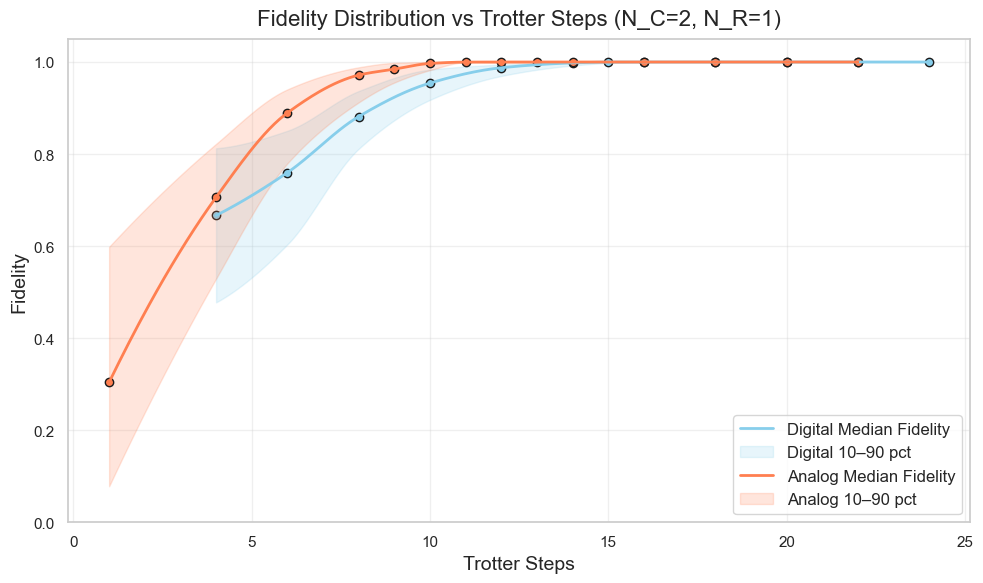

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

def plot_fidelity_distribution_vs_trotter(
    df,
    N_ctrl=2,
    N_R=1,
    lower_pct=10,
    upper_pct=90,
    fidelity_col='fidelities',
    figsize=(10, 6),
    title='Fidelity Distribution vs Trotter Steps',
    x_label='Trotter Steps',
    y_label='Fidelity',
    legend_fontsize=12,
    marker_size=6
):
    """
    For a single N_ctrl and N_R, compare Digital vs Analog by plotting:
      - A shaded band for the [lower_pct, upper_pct] percentile of fidelities
      - A solid line for the median fidelity

    This ensures only ONE main curve (plus shading) per model, i.e., 
    no second line for success probability.

    Args:
        df (pd.DataFrame): A DataFrame with columns:
            - 'Type' in ['Digital','Analog']
            - 'N_C' (number of control qubits)
            - 'N_R' (reservoir count)
            - 'Trotter_Step' (integer or float)
            - fidelity_col (str): each row is expected to have a list/array 
              of fidelity values or single floats. 
        N_ctrl (int): Number of control qubits to filter on.
        N_R (int): Reservoir count to filter on.
        lower_pct (float): Lower percentile for the fidelity band (default 10).
        upper_pct (float): Upper percentile for the fidelity band (default 90).
        fidelity_col (str): Column name in df that holds fidelity arrays or values (default 'fidelities').
        figsize (tuple): Size of the figure (default (10, 6)).
        title (str): Plot title.
        x_label (str): X-axis label.
        y_label (str): Y-axis label.
        legend_fontsize (int): Font size for the legend.
        marker_size (int): Size for any scatter markers.

    Returns:
        None. Displays a matplotlib figure.
    """
    # Set up figure
    plt.figure(figsize=figsize)

    # Filter DataFrame for the specified N_C and N_R
    df_filtered = df[(df['N_C'] == N_ctrl) & (df['N_R'] == N_R)].copy()
    if df_filtered.empty:
        print(f"No data found for N_C={N_ctrl} and N_R={N_R}!")
        return

    # We'll plot Digital vs Analog on the same axes
    model_pairs = [('Digital', 'skyblue'), ('Analog', 'coral')]

    for model_type, color in model_pairs:
        df_type = df_filtered[df_filtered['Type'] == model_type]
        if df_type.empty:
            continue
        
        # Group by Trotter_Step. For each step, flatten the fidelity arrays (if they are lists).
        stats_list = []
        for step, group in df_type.groupby('Trotter_Step'):
            # Flatten all fidelity values in this Trotter step
            if group[fidelity_col].dtype == object:
                # If entries are lists/arrays, concatenate
                all_fids = np.concatenate([
                    np.array(x, ndmin=1) for x in group[fidelity_col] if x is not None
                ])
            else:
                # If they're single floats, just take them directly
                all_fids = group[fidelity_col].values

            if len(all_fids) == 0:
                continue

            # Compute distribution stats
            median_fid = np.median(all_fids)
            pct_low_fid = np.percentile(all_fids, lower_pct)
            pct_high_fid = np.percentile(all_fids, upper_pct)

            stats_list.append({
                'Trotter_Step': step,
                'median_fid': median_fid,
                'pct_low_fid': pct_low_fid,
                'pct_high_fid': pct_high_fid
            })

        # Convert to DataFrame and sort by Trotter_Step
        stats_df = pd.DataFrame(stats_list).sort_values('Trotter_Step')
        if stats_df.empty:
            continue

        x_vals = stats_df['Trotter_Step'].values
        med_fid_vals = stats_df['median_fid'].values
        low_fid_vals = stats_df['pct_low_fid'].values
        high_fid_vals = stats_df['pct_high_fid'].values

        # Build PCHIP interpolators for smooth curves
        pchip_median_fid = PchipInterpolator(x_vals, med_fid_vals)
        pchip_low_fid = PchipInterpolator(x_vals, low_fid_vals)
        pchip_high_fid = PchipInterpolator(x_vals, high_fid_vals)

        # Evaluate on a fine x-grid
        x_fine = np.linspace(x_vals.min(), x_vals.max(), 300)
        med_smooth = pchip_median_fid(x_fine)
        low_smooth = pchip_low_fid(x_fine)
        high_smooth = pchip_high_fid(x_fine)

        # 1) Plot the median fidelity (solid line)
        plt.plot(
            x_fine, med_smooth, color=color, linestyle='-', linewidth=2,
            label=f'{model_type} Median Fidelity'
        )
        # 2) Fill between [low, high] fidelity
        plt.fill_between(
            x_fine, low_smooth, high_smooth, color=color, alpha=0.2,
            label=f'{model_type} {lower_pct}–{upper_pct} pct'
        )
        # 3) Scatter the actual points (median fidelity)
        plt.scatter(
            x_vals, med_fid_vals, color=color, edgecolor='k', s=marker_size**2
        )

    # Decorate
    plt.title(title, fontsize=16, pad=10)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.ylim([0.0, 1.05])  # Fidelity range from 0..1
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=legend_fontsize, loc='best')
    plt.tight_layout()
    plt.show()



plot_fidelity_distribution_vs_trotter(
    df=df_combined,
    N_ctrl=2,
    N_R=1,
    lower_pct=10,
    upper_pct=90,
    fidelity_col='fidelities',
    figsize=(10, 6),
    title='Fidelity Distribution vs Trotter Steps (N_C=2, N_R=1)',
    x_label='Trotter Steps',
    y_label='Fidelity',
    legend_fontsize=12,
    marker_size=6
)


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_46246/839127206.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.mean(g['Avg_Fidelity'] > success_threshold))
/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_46246/839127206.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.mean(g['Avg_Fidelity'] > success_threshold))
/var/folders/xx/w2tzbky1

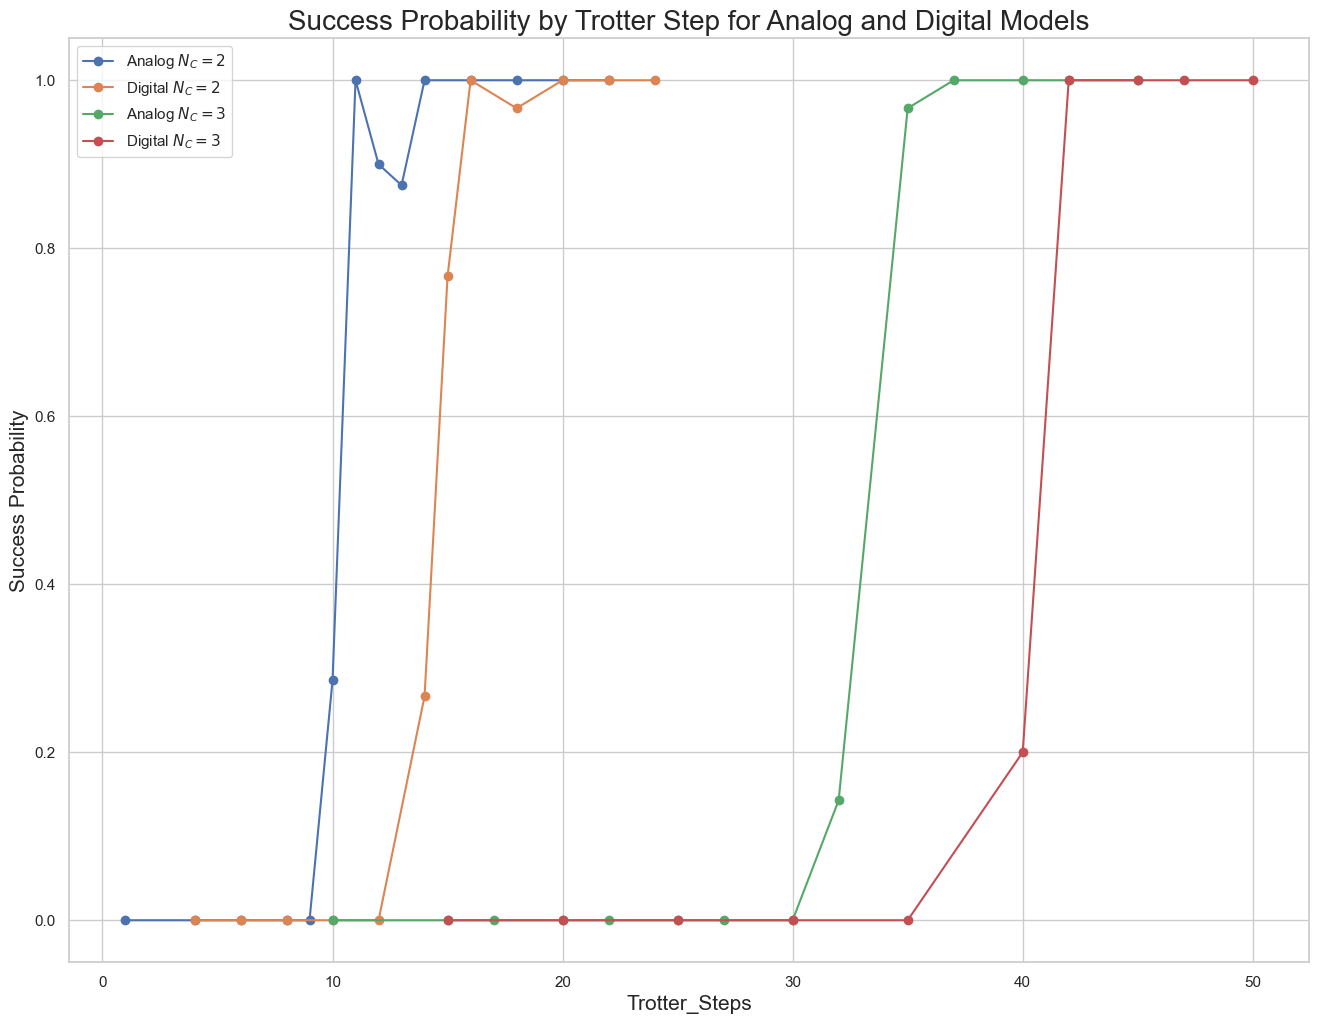

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Define success criteria (F > 0.99 => infidelity < 0.01)
# or equivalently "Avg_Fidelity > 0.999"
success_threshold = 0.999  

plt.figure(figsize=(16, 12))

# Determine which N_ctrl values are in df_combined
unique_nctrls = sorted(df_combined['N_C'].unique())

for N_ctrl in unique_nctrls:
    for model_type in ['Analog', 'Digital']:
        
        # Filter the DataFrame for the current N_ctrl, model type, and N_R=1
        df_filtered = df_combined[
            (df_combined['N_C'] == N_ctrl) &
            (df_combined['Type'] == model_type) &
            (df_combined['N_R'] == 1)
        ]
        
        # Group by Trotter_Step and compute success probability
        # success_probabilities is fraction of runs with Avg_Fidelity > success_threshold
        success_probabilities = (
            df_filtered
            .groupby('Trotter_Step')
            .apply(lambda g: np.mean(g['Avg_Fidelity'] > success_threshold))
            .reset_index(name='Success Probability')
        )
        
        # Plot success probability
        plt.plot(
            success_probabilities['Trotter_Step'], 
            success_probabilities['Success Probability'], 
            marker='o', 
            label=f'{model_type} $N_C = {N_ctrl}$'
        )

plt.title('Success Probability by Trotter Step for Analog and Digital Models', fontsize=20)
plt.xlabel('Trotter_Steps', fontsize=15)
plt.ylabel('Success Probability', fontsize=15)
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import PchipInterpolator

################################################################################
# 1) UPDATED FUNCTIONS (Switch "Reservoir Count" -> "N_R")
################################################################################

def plot_error_with_smoothed_bands(data_df, N_ctrl, N_R, xlabel, ylabel, title, 
                                   midpoint_metric='Total_Avg_Infidelity',
                                   std_metric='Error_Test_Results'):
    """
    Plot error statistics using the median and IQR for a list-based or scalar-based column.

    Args:
        data_df (pd.DataFrame): DataFrame containing columns like 'Trotter_Step', 'infidelities', etc.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): Reservoir count to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
        midpoint_metric (str): Column to treat as the 'central' value (e.g., average).
        std_metric (str): Column that may contain list(s) to compute median, IQR, etc.
    """

    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['N_R'] == N_R)].copy()

    # Flatten the std_metric column if it contains lists
    if std_metric in ['Error_Test_Results', 'infidelities']:
        filtered_df.loc[:, std_metric] = filtered_df[std_metric].apply(
            lambda x: np.concatenate(x) if isinstance(x, list) else x
        )
    elif std_metric in ['Avg Error', 'Avg_infidelity']:
        # Scalar metric, no flattening needed
        filtered_df.loc[:, std_metric] = filtered_df[std_metric]
    else:
        raise ValueError(f"Unexpected std_metric: {std_metric}")

    # Ensure there are no NaNs in the std_metric column
    if filtered_df[std_metric].isna().any():
        raise ValueError("NaN values detected in the specified std_metric column! Check the data preprocessing step.")

    print("Calculating median and IQR...")
    # Group by 'Trotter_Step' and calculate median, 20th, 80th percentile, mean, etc.
    stats = (
        filtered_df.groupby('Trotter_Step', group_keys=False)
        .apply(lambda group: pd.Series({
            'median': np.median(np.concatenate(group[std_metric].values)),
            'lower_bound': np.percentile(np.concatenate(group[std_metric].values), 20),
            'upper_bound': np.percentile(np.concatenate(group[std_metric].values), 80),
            'avg': np.mean(np.concatenate(group[std_metric].values)),
            'std': np.std(np.concatenate(group[std_metric].values))
        }))
        .reset_index()
    )

    # Create PCHIP interpolators for a smooth curve
    pchip_median = PchipInterpolator(stats['Trotter_Step'], stats['median'])
    pchip_lower = PchipInterpolator(stats['Trotter_Step'], stats['lower_bound'])
    pchip_upper = PchipInterpolator(stats['Trotter_Step'], stats['upper_bound'])

    # Fine-grained x-axis for smooth plotting
    x_fine = np.linspace(stats['Trotter_Step'].min(), stats['Trotter_Step'].max(), 300)

    median_smooth = pchip_median(x_fine)
    lower_smooth = pchip_lower(x_fine)
    upper_smooth = pchip_upper(x_fine)

    # Plot
    fig, axs = plt.subplots(figsize=(10, 6))
    plt.plot(x_fine, median_smooth, linestyle='--', lw=1, color='blue')
    plt.scatter(stats['Trotter_Step'], stats['median'], label='Median', marker='D', color='dodgerblue')
    plt.scatter(stats['Trotter_Step'], stats['avg'], label='Avg', marker='x', color='red')
    plt.fill_between(x_fine, lower_smooth, upper_smooth, color='blue', alpha=0.2, label='IQR (Q3 - Q1)')

    # Optional: adjust y-ticks if you want powers-of-10 style
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick + 1, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Set a limited number of x-ticks
    num_ticks = 10
    x_ticks = np.linspace(min(stats['Trotter_Step']), max(stats['Trotter_Step']), num_ticks, dtype=int)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels([str(tick) for tick in x_ticks])

    # Customize
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_error_with_smoothed_bands_std(data_df, N_ctrl, N_R, xlabel, ylabel, title, 
                                       midpoint_metric='Total_Avg_Infidelity',
                                       std_metric='Error_Test_Results'):
    """
    Similar to plot_error_with_smoothed_bands but uses mean +/- (std/2) as the band.
    """

    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['N_R'] == N_R)].copy()

    # Flatten the std_metric column if it contains lists
    if std_metric in ['Error_Test_Results', 'infidelities']:
        filtered_df.loc[:, std_metric] = filtered_df[std_metric].apply(
            lambda x: np.concatenate(x) if isinstance(x, list) else x
        )
    elif std_metric in ['Avg Error', 'Avg_infidelity']:
        filtered_df.loc[:, std_metric] = filtered_df[std_metric]
    else:
        raise ValueError(f"Unexpected std_metric: {std_metric}")

    if filtered_df[std_metric].isna().any():
        raise ValueError("NaN values detected in the specified std_metric column! Check the data preprocessing step.")

    print("Calculating mean +/- std/2 ...")
    stats = (
        filtered_df.groupby('Trotter_Step', group_keys=False)
        .apply(lambda group: pd.Series({
            'median': np.median(np.concatenate(group[std_metric].values)),
            'q1': np.percentile(np.concatenate(group[std_metric].values), 25),
            'q3': np.percentile(np.concatenate(group[std_metric].values), 75),
            'avg': np.mean(np.concatenate(group[std_metric].values)),
            'lower_bound': np.mean(np.concatenate(group[std_metric].values)) - np.std(np.concatenate(group[std_metric].values)) / 2,
            'upper_bound': np.mean(np.concatenate(group[std_metric].values)) + np.std(np.concatenate(group[std_metric].values)) / 2
        }))
        .reset_index()
    )

    pchip_median = PchipInterpolator(stats['Trotter_Step'], stats['median'])
    pchip_mean = PchipInterpolator(stats['Trotter_Step'], stats['avg'])
    pchip_lower = PchipInterpolator(stats['Trotter_Step'], stats['lower_bound'])
    pchip_upper = PchipInterpolator(stats['Trotter_Step'], stats['upper_bound'])

    x_fine = np.linspace(stats['Trotter_Step'].min(), stats['Trotter_Step'].max(), 300)
    median_smooth = pchip_median(x_fine)
    lower_smooth = pchip_lower(x_fine)
    upper_smooth = pchip_upper(x_fine)

    fig, axs = plt.subplots(figsize=(10, 6))
    plt.plot(x_fine, median_smooth, linestyle='--', lw=1, color='blue')
    plt.scatter(stats['Trotter_Step'], stats['median'], label='Median', marker='D', color='dodgerblue')
    plt.scatter(stats['Trotter_Step'], stats['avg'], label='Avg', marker='x', color='red')
    plt.fill_between(x_fine, lower_smooth, upper_smooth, color='blue', alpha=0.2, label='Mean ± std/2')

    # Optional: adjust y-ticks for powers-of-10
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick + 1, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # X-axis ticks
    num_ticks = 10
    x_ticks = np.linspace(min(stats['Trotter_Step']), max(stats['Trotter_Step']), num_ticks, dtype=int)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels([str(tick) for tick in x_ticks])

    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


################################################################################
# 2) AGGREGATE YOUR DATAFRAME (REPLACING 'Reservoir Count' WITH 'N_R')
################################################################################
# Suppose 'all_data_df' is your final combined DataFrame 
# containing columns like 'infidelities', 'Error_Test_Results', 'Avg Error', etc.

aggregated_data = (
    all_data_df
    .groupby(['Trotter_Step', 'N_R', 'N_C', 'N_params'])
    .agg({
        'infidelities': lambda x: np.concatenate(x.values),    # Flatten lists
        'Error_Test_Results': lambda x: np.concatenate(x.values), 
        'Avg_infidelity': list,    # If these columns are floats, store them as lists
        'Avg Error': list,         # or you could do 'np.mean' if you prefer
    })
    .reset_index()
)

# Add some convenience columns
aggregated_data['Total_Avg_Error'] = aggregated_data['Error_Test_Results'].apply(np.mean)
aggregated_data['Total_Avg_Infidelity'] = aggregated_data['infidelities'].apply(np.mean)
aggregated_data['Median_Error'] = aggregated_data['Error_Test_Results'].apply(np.median)
aggregated_data['Median_infidelity'] = aggregated_data['infidelities'].apply(np.median)

################################################################################
# 3) PLOT FOR A SPECIFIC N_ctrl
################################################################################
# Example: N_ctrl = 2, N_R = 1 => uses the first function (IQR bands)
plot_error_with_smoothed_bands(
    data_df=aggregated_data,
    N_ctrl=2,
    N_R=1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps',
    midpoint_metric='Total_Avg_Error',
    std_metric='Error_Test_Results'
)

# Example: N_ctrl = 2, N_R = 2 => uses the second function (mean ± std/2)
plot_error_with_smoothed_bands_std(
    data_df=aggregated_data,
    N_ctrl=2,
    N_R=2,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps',
    midpoint_metric='Total_Avg_Error',  # or 'Avg Error'
    std_metric='Error_Test_Results'
)

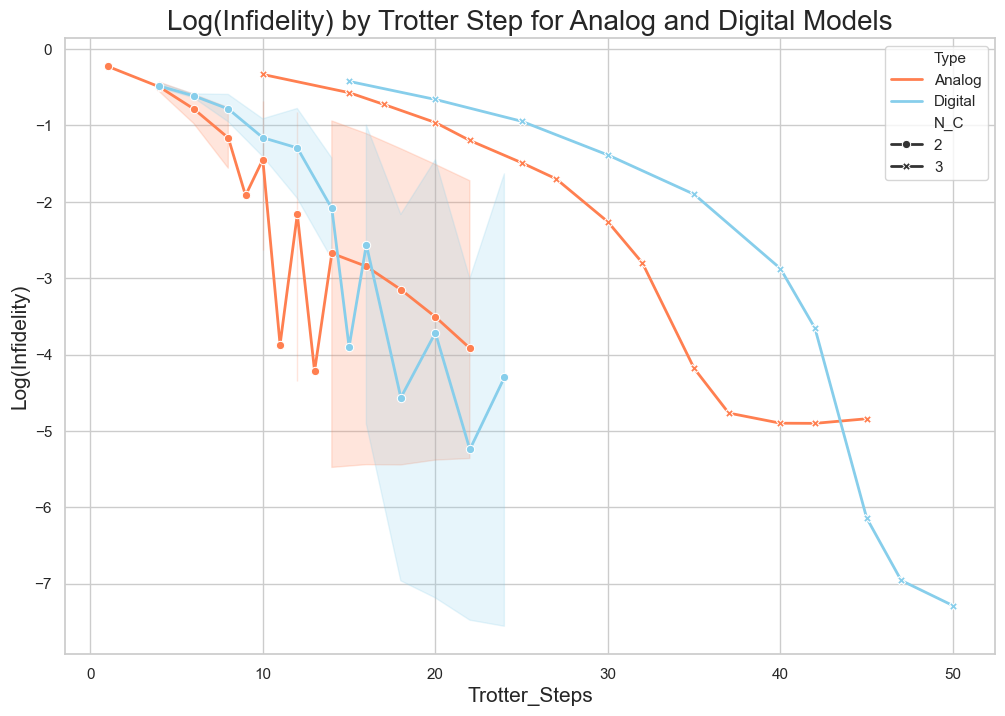

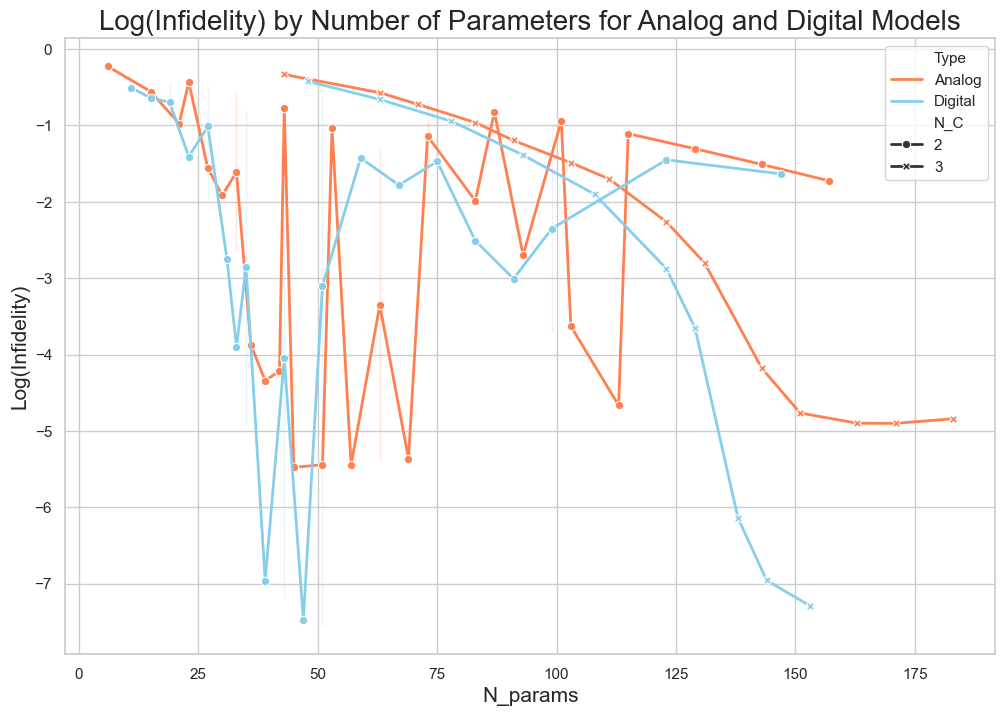

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# 1) Group/Aggregate
# ------------------------------
plt.figure(figsize=(12, 8))

# Group by Trotter_Step, Type, N_C, N_R, and N_params, then take the mean of 'Avg Error'
df_combined_agg = (
    df_combined
    .groupby(['Trotter_Step', 'Type', 'N_C', 'N_R', 'N_params'])
    .agg({'Avg Error': 'mean'})
    .reset_index()
)

# ------------------------------
# 2) Plot vs Trotter_Step
# ------------------------------
sns.lineplot(
    x='Trotter_Step', 
    y='Avg Error', 
    hue='Type', 
    style='N_C',  # Distinguish lines by N_ctrl (1, 2, 3)
    markers=True, 
    dashes=False, 
    data=df_combined_agg,
    palette={'Analog': 'coral', 'Digital': 'skyblue'},
    linewidth=2
)

plt.title('Log(Infidelity) by Trotter Step for Analog and Digital Models', fontsize=20)
plt.xlabel('Trotter_Steps', fontsize=15)
plt.ylabel('Log(Infidelity)', fontsize=15)
plt.legend()
plt.show()

# ------------------------------
# 3) Plot vs N_params
# ------------------------------
plt.figure(figsize=(12, 8))

sns.lineplot(
    x='N_params', 
    y='Avg Error', 
    hue='Type', 
    style='N_C',  # Distinguish lines by N_ctrl (1, 2, 3)
    markers=True, 
    dashes=False, 
    data=df_combined_agg,
    palette={'Analog': 'coral', 'Digital': 'skyblue'},
    linewidth=2
)

plt.title('Log(Infidelity) by Number of Parameters for Analog and Digital Models', fontsize=20)
plt.xlabel('N_params', fontsize=15)
plt.ylabel('Log(Infidelity)', fontsize=15)
plt.legend()
plt.show()

In [ ]:
|
